In [1]:
!pip install pingouin

In [2]:
import pandas as pd
from scipy.stats import shapiro
import numpy as np
import pingouin as pg
import matplotlib.pyplot as plt

In [3]:
tent_log_file = 'tent_log_2025-04-04.csv'
train_log_file = 'train_experiment_log_2025-04-04.csv'
alpha = 0.05 

In [4]:
tent_df = pd.read_csv(tent_log_file)
train_df = pd.read_csv(train_log_file)

In [5]:
tent_data = tent_df[['experiment_name','train_source', 'accuracy', 'f1']].rename(
    columns={'accuracy': 'tent_accuracy', 'f1': 'tent_f1'}
)
original_data = train_df[['experiment_name', 'train_source', 'accuracy', 'f1']].rename(
    columns={'accuracy': 'original_accuracy', 'f1': 'original_f1'}
)

merged_df = pd.merge(
    tent_data, original_data, on=['experiment_name', 'train_source'], how='inner'
)


In [6]:
def perform_paired_analysis(df, tent_metric_col, original_metric_col, metric_name):
    tent_metric = df[tent_metric_col]
    original_metric = df[original_metric_col]
    
    
    print(f"Performing paired analysis for {metric_name}...")
    diff = tent_metric - original_metric
    stats, p_value = shapiro(diff)
    print(f"Shapiro-Wilk test for normality: W={stats:.4f}, p-value={p_value:.4f}")
    is_normal = p_value > alpha
    print(f"Normality assumption met: {is_normal}")
    if is_normal:
        print("Performing paired t-test...")
        test_result = pg.ttest(tent_metric, original_metric, paired=True, alternative='greater')
        effect_size_name = "Paired Cohen's d"
        effect_size = test_result['cohen-d'].iloc[0] 
    else:
        test_result = pg.wilcoxon(tent_metric, original_metric, alternative='greater')
        effect_size_name = "Rank-Biserial Correlation (RBC)"
        effect_size = test_result['RBC'].values[0]
    print(test_result.round(4))

    p_value = test_result['p-val'].iloc[0]
    print(f"\nInterpretation for {metric_name}:")
    if p_value <= alpha:
        print(f"  Reject H0 (p={p_value:.4f} <= {alpha}). There is significant evidence to suggest that TENT performs better than the original.")
    else:
        print(f"  Fail to reject H0 (p={p_value:.4f} > {alpha}). There is not enough significant evidence to suggest that TENT performs better than the original.")

    print(f"Effect size ({effect_size_name}): {effect_size:.4f}")

    print(f"Mean difference: {np.mean(diff):.4f}")
    print(f"Standard deviation of differences: {np.std(diff, ddof=1):.4f}")
    # plot diff on a histogram
    plt.hist(diff, bins=20)
    plt.title(f"Histogram of differences ({metric_name})")
    plt.xlabel('Difference')
    plt.ylabel('Frequency')
    plt.show()

Performing paired analysis for Accuracy...
Shapiro-Wilk test for normality: W=0.9403, p-value=0.0695
Normality assumption met: True
Performing paired t-test...
             T  dof alternative  p-val         CI95%  cohen-d       BF10  \
T-test  8.5114   32     greater    0.0  [12.05, inf]   0.7374  2.277e+07   

         power  
T-test  0.9938  

Interpretation for Accuracy:
  Reject H0 (p=0.0000 <= 0.05). There is significant evidence to suggest that TENT performs better than the original.
Effect size (Paired Cohen's d): 0.7374
Mean difference: 15.0424
Standard deviation of differences: 10.1525


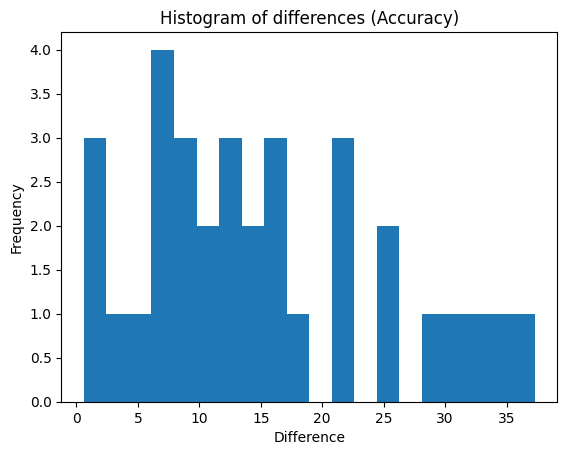

In [7]:
perform_paired_analysis(merged_df, 'tent_accuracy', 'original_accuracy', 'Accuracy')


Performing paired analysis for F1-Score...
Shapiro-Wilk test for normality: W=0.9015, p-value=0.0058
Normality assumption met: False
          W-val alternative  p-val  RBC    CLES
Wilcoxon  561.0     greater    0.0  1.0  0.6896

Interpretation for F1-Score:
  Reject H0 (p=0.0000 <= 0.05). There is significant evidence to suggest that TENT performs better than the original.
Effect size (Rank-Biserial Correlation (RBC)): 1.0000
Mean difference: 0.1397
Standard deviation of differences: 0.1174


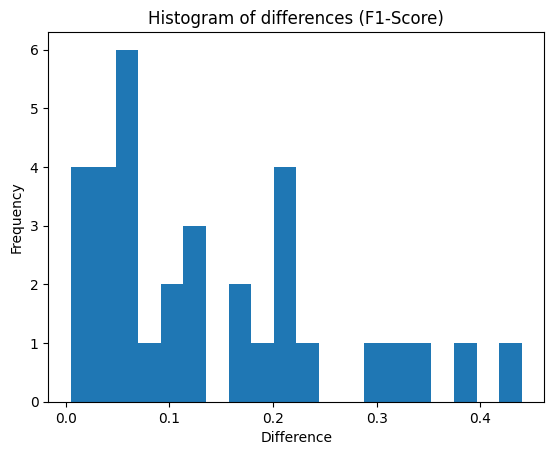

In [8]:
perform_paired_analysis(merged_df, 'tent_f1', 'original_f1', 'F1-Score')

now we have established that tent improves the performance in overall experiments. lets test how well it works in domain adaptation

In [9]:
noise = ["blured", "gaussian", "poisson"]
data_source = [ "organamnist", "organcmnist", "organsmnist"]

noisy_data = []
for source in data_source:
    for noise_type in noise:
        noisy_data.append(f"{source}_{noise_type}")
tent_df_domain = tent_df[~tent_df["experiment_name"].isin(noisy_data)]
train_df_domain = train_df[~train_df["experiment_name"].isin(noisy_data)]
tent_df_domain = tent_df_domain[['experiment_name','train_source', 'accuracy', 'f1']].rename(
    columns={'accuracy': 'tent_accuracy', 'f1': 'tent_f1'}
)
original_data_domain = train_df_domain[['experiment_name', 'train_source', 'accuracy', 'f1']].rename(
    columns={'accuracy': 'original_accuracy', 'f1': 'original_f1'}
)

merged_df_domain = pd.merge(
    tent_df_domain, original_data_domain, on=['experiment_name', 'train_source'], how='inner'
)

In [10]:
merged_df_domain

,experiment_name,train_source,tent_accuracy,tent_f1,original_accuracy,original_f1
0,organcmnist,organamnist,79.553068,0.778953,71.623627,0.730609
1,organsmnist,organamnist,40.426797,0.382623,34.179525,0.352577
2,organamnist,organcmnist,75.478500,0.745177,63.117457,0.677785
3,organsmnist,organcmnist,59.283644,0.542781,50.236008,0.460691
4,organamnist,organsmnist,46.613973,0.429241,38.493966,0.390860
5,organcmnist,organsmnist,75.711316,0.701208,72.781241,0.677235


Performing paired analysis for Accuracy (domain Data)...
Shapiro-Wilk test for normality: W=0.9702, p-value=0.8937
Normality assumption met: True
Performing paired t-test...
             T  dof alternative   p-val        CI95%  cohen-d    BF10  power
T-test  6.1066    5     greater  0.0009  [5.21, inf]    0.467  53.023  0.257

Interpretation for Accuracy (domain Data):
  Reject H0 (p=0.0009 <= 0.05). There is significant evidence to suggest that TENT performs better than the original.
Effect size (Paired Cohen's d): 0.4670
Mean difference: 7.7726
Standard deviation of differences: 3.1177


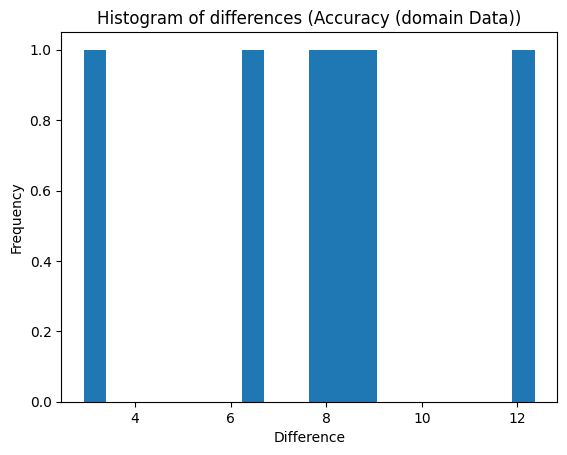

In [11]:
perform_paired_analysis(merged_df_domain, 'tent_accuracy', 'original_accuracy', 'Accuracy (domain Data)')

Performing paired analysis for F1-Score (Domain Data)...
Shapiro-Wilk test for normality: W=0.9387, p-value=0.6490
Normality assumption met: True
Performing paired t-test...
             T  dof alternative   p-val        CI95%  cohen-d    BF10   power
T-test  5.2677    5     greater  0.0016  [0.03, inf]   0.2889  32.154  0.1518

Interpretation for F1-Score (Domain Data):
  Reject H0 (p=0.0016 <= 0.05). There is significant evidence to suggest that TENT performs better than the original.
Effect size (Paired Cohen's d): 0.2889
Mean difference: 0.0484
Standard deviation of differences: 0.0225


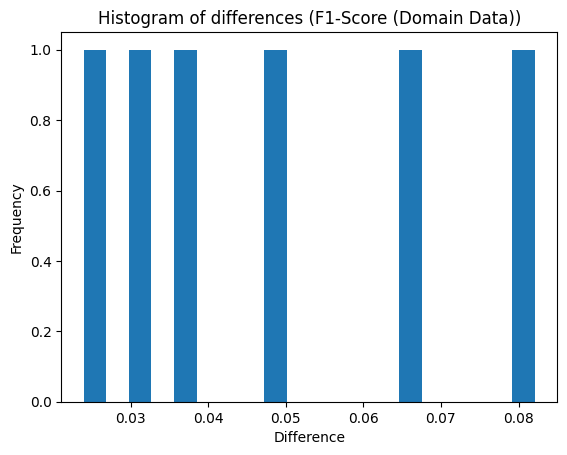

In [12]:
perform_paired_analysis(merged_df_domain, 'tent_f1', 'original_f1', 'F1-Score (Domain Data)')

In [13]:
tent_df_noisy = tent_df[tent_df["experiment_name"].isin(noisy_data)]
train_df_noisy = train_df[train_df["experiment_name"].isin(noisy_data)]
tent_df_noisy = tent_df_noisy[['experiment_name','train_source', 'accuracy', 'f1']].rename(
    columns={'accuracy': 'tent_accuracy', 'f1': 'tent_f1'}
)
original_data_noisy = train_df_noisy[['experiment_name', 'train_source', 'accuracy', 'f1']].rename(
    columns={'accuracy': 'original_accuracy', 'f1': 'original_f1'}
)
merged_df_noisy = pd.merge(
    tent_df_noisy, original_data_noisy, on=['experiment_name', 'train_source'], how='inner'
)

In [14]:
merged_df_noisy

,experiment_name,train_source,tent_accuracy,tent_f1,original_accuracy,original_f1
0,organamnist_blured,organamnist,97.156215,0.969895,80.948496,0.845278
1,organamnist_gaussian,organamnist,98.188001,0.979722,97.285399,0.971716
2,organamnist_poisson,organamnist,95.153832,0.947381,62.996770,0.507478
3,organcmnist_blured,organamnist,76.826525,0.757890,46.508078,0.514359
4,organcmnist_gaussian,organamnist,79.536104,0.779732,69.919009,0.716585
5,organcmnist_poisson,organamnist,73.544502,0.726344,44.680490,0.381197
6,organsmnist_blured,organamnist,38.391972,0.367005,23.025663,0.233065
7,organsmnist_gaussian,organamnist,40.458530,0.381874,34.925231,0.350572
8,organsmnist_poisson,organamnist,37.586766,0.361762,25.195351,0.179310
9,organamnist_blured,organcmnist,70.832908,0.708760,35.724970,0.394648


Performing paired analysis for Accuracy (Noisy Data)...
Shapiro-Wilk test for normality: W=0.9613, p-value=0.3963
Normality assumption met: True
Performing paired t-test...
             T  dof alternative  p-val         CI95%  cohen-d       BF10  \
T-test  8.2497   26     greater    0.0  [13.21, inf]   0.7819  2.615e+06   

         power  
T-test  0.9895  

Interpretation for Accuracy (Noisy Data):
  Reject H0 (p=0.0000 <= 0.05). There is significant evidence to suggest that TENT performs better than the original.
Effect size (Paired Cohen's d): 0.7819
Mean difference: 16.6579
Standard deviation of differences: 10.4921


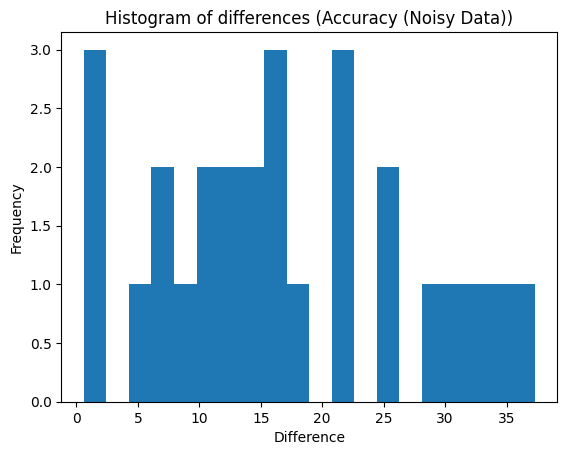

In [15]:
perform_paired_analysis(merged_df_noisy, 'tent_accuracy', 'original_accuracy', 'Accuracy (Noisy Data)')

Performing paired analysis for F1-Score (Noisy Data)...
Shapiro-Wilk test for normality: W=0.9407, p-value=0.1267
Normality assumption met: True
Performing paired t-test...
             T  dof alternative  p-val        CI95%  cohen-d       BF10  \
T-test  6.9034   26     greater    0.0  [0.12, inf]   0.7253  1.286e+05   

         power  
T-test  0.9785  

Interpretation for F1-Score (Noisy Data):
  Reject H0 (p=0.0000 <= 0.05). There is significant evidence to suggest that TENT performs better than the original.
Effect size (Paired Cohen's d): 0.7253
Mean difference: 0.1600
Standard deviation of differences: 0.1205


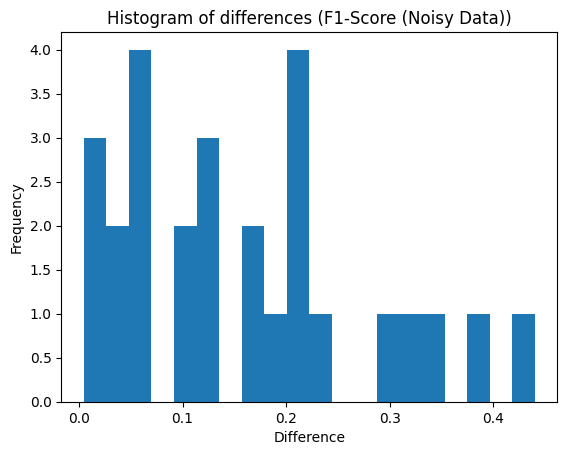

In [16]:
perform_paired_analysis(merged_df_noisy, 'tent_f1', 'original_f1', 'F1-Score (Noisy Data)')

In [17]:
tent_mmd_log_file = 'tent_log_MMD_2025-04-05.csv'
train_mmd_log_file = 'train_experiment_log_MMD_2025-04-05.csv'
tent_mmd_df = pd.read_csv(tent_mmd_log_file)
train_mmd_df = pd.read_csv(train_mmd_log_file)
tent_mmd_data = tent_mmd_df[['experiment_name','train_source', 'accuracy', 'f1']].rename(
    columns={'accuracy': 'tent_accuracy', 'f1': 'tent_f1'}
)
original_mmd_data = train_mmd_df[['experiment_name', 'train_source', 'accuracy', 'f1']].rename(
    columns={'accuracy': 'original_accuracy', 'f1': 'original_f1'}
)
merged_mmd_df = pd.merge(
    tent_mmd_data, original_mmd_data, on=['experiment_name', 'train_source'], how='inner'
)

Performing paired analysis for Accuracy (MMD)...
Shapiro-Wilk test for normality: W=0.9369, p-value=0.0551
Normality assumption met: True
Performing paired t-test...
             T  dof alternative  p-val        CI95%  cohen-d       BF10  power
T-test  6.8425   32     greater    0.0  [12.0, inf]   0.7823  3.074e+05  0.997

Interpretation for Accuracy (MMD):
  Reject H0 (p=0.0000 <= 0.05). There is significant evidence to suggest that TENT performs better than the original.
Effect size (Paired Cohen's d): 0.7823
Mean difference: 15.9487
Standard deviation of differences: 13.3896


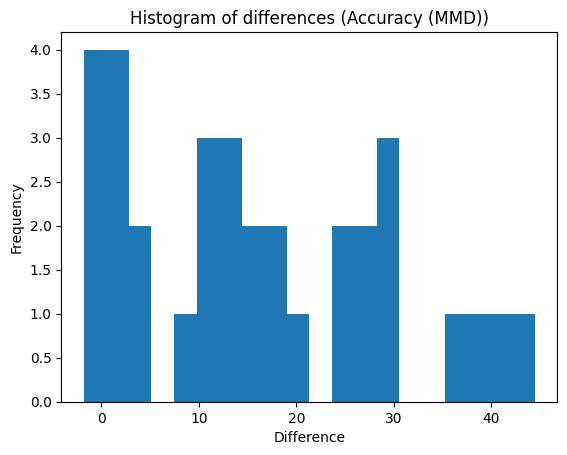

In [18]:
perform_paired_analysis(merged_mmd_df, 'tent_accuracy', 'original_accuracy', 'Accuracy (MMD)')

Performing paired analysis for F1-Score (MMD)...
Shapiro-Wilk test for normality: W=0.9408, p-value=0.0715
Normality assumption met: True
Performing paired t-test...
             T  dof alternative  p-val        CI95%  cohen-d       BF10  \
T-test  6.9796   32     greater    0.0  [0.14, inf]   0.8284  4.417e+05   

         power  
T-test  0.9987  

Interpretation for F1-Score (MMD):
  Reject H0 (p=0.0000 <= 0.05). There is significant evidence to suggest that TENT performs better than the original.
Effect size (Paired Cohen's d): 0.8284
Mean difference: 0.1787
Standard deviation of differences: 0.1471


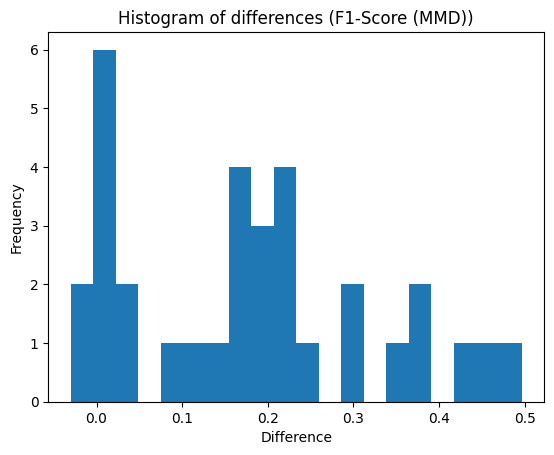

In [19]:
perform_paired_analysis(merged_mmd_df, 'tent_f1', 'original_f1', 'F1-Score (MMD)')

In [20]:
tent_mmd_df_noisy = tent_mmd_df[tent_mmd_df["experiment_name"].isin(noisy_data)]
train_mmd_df_noisy = train_mmd_df[train_mmd_df["experiment_name"].isin(noisy_data)]
tent_mmd_df_noisy = tent_mmd_df_noisy[['experiment_name','train_source', 'accuracy', 'f1']].rename(
    columns={'accuracy': 'tent_accuracy', 'f1': 'tent_f1'}
)
original_mmd_data_noisy = train_mmd_df_noisy[['experiment_name', 'train_source', 'accuracy', 'f1']].rename(
    columns={'accuracy': 'original_accuracy', 'f1': 'original_f1'}
)
merged_mmd_df_noisy = pd.merge(
    tent_mmd_df_noisy, original_mmd_data_noisy, on=['experiment_name', 'train_source'], how='inner'
)

In [21]:
merged_mmd_df_noisy

,experiment_name,train_source,tent_accuracy,tent_f1,original_accuracy,original_f1
0,organamnist_blured,organamnist,95.937449,0.956037,86.155023,0.824044
1,organamnist_gaussian,organamnist,96.860445,0.965550,81.174571,0.734907
2,organamnist_poisson,organamnist,92.544621,0.915822,52.272650,0.419312
3,organcmnist_blured,organamnist,77.259040,0.759071,47.080524,0.462736
4,organcmnist_gaussian,organamnist,78.870374,0.772140,42.598482,0.408147
5,organcmnist_poisson,organamnist,72.641307,0.710683,28.202519,0.261020
6,organsmnist_blured,organamnist,39.042482,0.376055,27.150847,0.195450
7,organsmnist_gaussian,organamnist,41.501725,0.392482,27.610963,0.199275
8,organsmnist_poisson,organamnist,37.269446,0.357396,22.894768,0.133237
9,organamnist_blured,organcmnist,66.202617,0.668639,42.498725,0.500694


Performing paired analysis for Accuracy (MMD Noisy Data)...
Shapiro-Wilk test for normality: W=0.9517, p-value=0.2357
Normality assumption met: True
Performing paired t-test...
             T  dof alternative  p-val         CI95%  cohen-d       BF10  \
T-test  7.2316   26     greater    0.0  [13.82, inf]   0.8523  2.726e+05   

         power  
T-test  0.9961  

Interpretation for Accuracy (MMD Noisy Data):
  Reject H0 (p=0.0000 <= 0.05). There is significant evidence to suggest that TENT performs better than the original.
Effect size (Paired Cohen's d): 0.8523
Mean difference: 18.0889
Standard deviation of differences: 12.9976


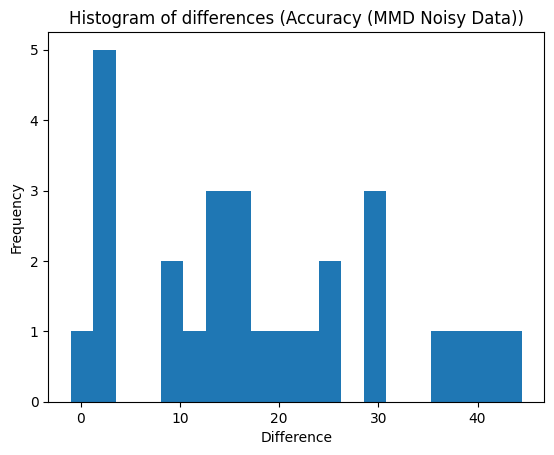

In [22]:
perform_paired_analysis(merged_mmd_df_noisy, 'tent_accuracy', 'original_accuracy', 'Accuracy (MMD Noisy Data)')

Performing paired analysis for F1-Score (MMD Noisy Data)...
Shapiro-Wilk test for normality: W=0.9500, p-value=0.2149
Normality assumption met: True
Performing paired t-test...
            T  dof alternative  p-val        CI95%  cohen-d       BF10   power
T-test  7.355   26     greater    0.0  [0.16, inf]   0.9069  3.607e+05  0.9984

Interpretation for F1-Score (MMD Noisy Data):
  Reject H0 (p=0.0000 <= 0.05). There is significant evidence to suggest that TENT performs better than the original.
Effect size (Paired Cohen's d): 0.9069
Mean difference: 0.2037
Standard deviation of differences: 0.1439


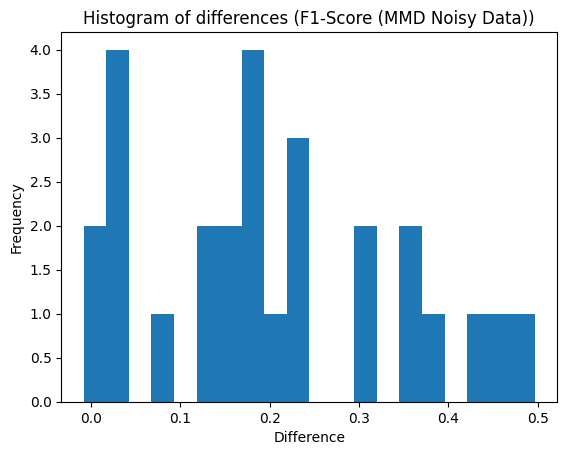

In [23]:
perform_paired_analysis(merged_mmd_df_noisy, 'tent_f1', 'original_f1', 'F1-Score (MMD Noisy Data)')

In [24]:
tent_mmd_df_domain = tent_mmd_df[~tent_mmd_df["experiment_name"].isin(noisy_data)]
train_mmd_df_domain = train_mmd_df[~train_mmd_df["experiment_name"].isin(noisy_data)]
tent_mmd_df_domain = tent_mmd_df_domain[['experiment_name','train_source', 'accuracy', 'f1']].rename(
    columns={'accuracy': 'tent_accuracy', 'f1': 'tent_f1'}
)
original_mmd_data_domain = train_mmd_df_domain[['experiment_name', 'train_source', 'accuracy', 'f1']].rename(
    columns={'accuracy': 'original_accuracy', 'f1': 'original_f1'}
)
merged_mmd_df_domain = pd.merge(
    tent_mmd_df_domain, original_mmd_data_domain, on=['experiment_name', 'train_source'], how='inner'
)

In [25]:
merged_mmd_df_domain

,experiment_name,train_source,tent_accuracy,tent_f1,original_accuracy,original_f1
0,organcmnist,organamnist,79.001826,0.770832,51.418395,0.520756
1,organsmnist,organamnist,42.076871,0.399789,30.272500,0.242995
2,organamnist,organcmnist,71.608025,0.711805,73.394527,0.741972
3,organsmnist,organcmnist,56.788701,0.523205,56.185792,0.509493
4,organamnist,organsmnist,42.578617,0.381654,42.537821,0.380581
5,organcmnist,organsmnist,74.074543,0.684746,74.413773,0.677324


Performing paired analysis for Accuracy (MMD Domain Data)...
Shapiro-Wilk test for normality: W=0.7514, p-value=0.0205
Normality assumption met: False
          W-val alternative   p-val     RBC    CLES
Wilcoxon   15.0     greater  0.2188  0.4286  0.6111

Interpretation for Accuracy (MMD Domain Data):
  Fail to reject H0 (p=0.2188 > 0.05). There is not enough significant evidence to suggest that TENT performs better than the original.
Effect size (Rank-Biserial Correlation (RBC)): 0.4286
Mean difference: 6.3176
Standard deviation of differences: 11.5272


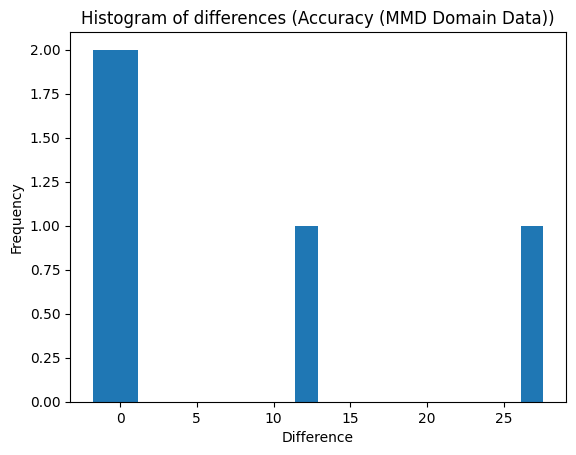

In [26]:
perform_paired_analysis(merged_mmd_df_domain, 'tent_accuracy', 'original_accuracy', 'Accuracy (MMD Domain Data)')


Performing paired analysis for F1-Score (MMD Domain Data)...
Shapiro-Wilk test for normality: W=0.8158, p-value=0.0812
Normality assumption met: True
Performing paired t-test...
             T  dof alternative   p-val         CI95%  cohen-d   BF10   power
T-test  1.4654    5     greater  0.1014  [-0.02, inf]   0.3778  1.569  0.2002

Interpretation for F1-Score (MMD Domain Data):
  Fail to reject H0 (p=0.1014 > 0.05). There is not enough significant evidence to suggest that TENT performs better than the original.
Effect size (Paired Cohen's d): 0.3778
Mean difference: 0.0665
Standard deviation of differences: 0.1111


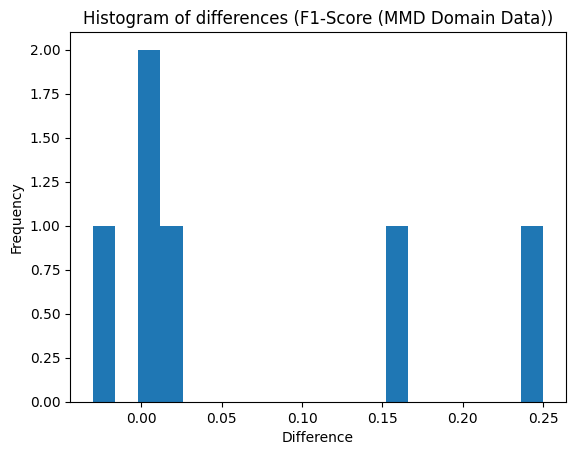

In [27]:
perform_paired_analysis(merged_mmd_df_domain, 'tent_f1', 'original_f1', 'F1-Score (MMD Domain Data)')

In [28]:
import re

log_path = '/home/harsh/Lab_Work/experiment_log_MMD_2025-04-12.txt'

tent_pattern = r"TENT testing time: ([\d.]+) seconds for (\d+) samples"
adapted_pattern = r"Adapted model inference time: ([\d.]+) seconds for (\d+) batches."

total_tent_time = 0.0
total_samples = 0
tent_lines = []
adapted_time = None
count = 0

with open(log_path, 'r') as file:
    for line in file:
        tent_match = re.search(tent_pattern, line)
        if tent_match:
            tent_lines.append(line.strip())
            time = float(tent_match.group(1))
            samples = int(tent_match.group(2))
            total_tent_time += time
            total_samples += samples
            count += 1

        adapted_match = re.search(adapted_pattern, line)
        if adapted_match:
            adapted_time = float(adapted_match.group(1))

# Calculate average times
tent_avg = total_tent_time / total_samples if total_samples > 0 else 0.0
adapted_avg = adapted_time / total_samples if adapted_time is not None and total_samples > 0 else None

print(f"mean of tent time: {total_tent_time/count:.6f}")
print(f"mean of adapted time: {adapted_time/count:.6f}")

print(f"\nTENT avg time/sample: {tent_avg:.6f} seconds")

if adapted_avg is not None:
    print(f"Adapted model avg time/sample: {adapted_avg:.6f} seconds")
else:
    print("Adapted model inference time not found.")


mean of tent time: 238.472727
mean of adapted time: 0.007306

TENT avg time/sample: 0.006647 seconds
Adapted model avg time/sample: 0.000000 seconds


In [29]:
# /home/harsh/Lab_Work/experiment_log_2025-04-12.txt
experiment_log_file = '/home/harsh/Lab_Work/experiment_log_2025-04-12.txt'
tent_pattern = r"TENT testing time: ([\d.]+) seconds for (\d+) samples"
adapted_pattern = r"Adapted model inference time: ([\d.]+) seconds for (\d+) batches."
total_tent_time = 0.0
total_samples = 0
tent_lines = []
adapted_time = None
count = 0

with open(experiment_log_file, 'r') as file:
    for line in file:
        tent_match = re.search(tent_pattern, line)
        if tent_match:
            tent_lines.append(line.strip())
            time = float(tent_match.group(1))
            samples = int(tent_match.group(2))
            total_tent_time += time
            total_samples += samples
            count += 1

        adapted_match = re.search(adapted_pattern, line)
        if adapted_match:
            adapted_time = float(adapted_match.group(1))

tent_avg = total_tent_time / total_samples if total_samples > 0 else 0.0
adapted_avg = adapted_time / total_samples if adapted_time is not None and total_samples > 0 else None

print(f"mean of tent time: {total_tent_time/count:.6f}")
print(f"mean of adapted time: {adapted_time/count:.6f}")

print(f"\nTENT avg time/sample: {tent_avg:.6f} seconds")
if adapted_avg is not None:
    print(f"Adapted model avg time/sample: {adapted_avg:.6f} seconds")
else:
    print("Adapted model inference time not found.")

mean of tent time: 25.746970
mean of adapted time: 0.007418

TENT avg time/sample: 0.000718 seconds
Adapted model avg time/sample: 0.000000 seconds
